In [1]:
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
import pydicom as com
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os

In [2]:
class rsna_dataset(Dataset):
    def __init__(self, data_df, transforms=None):
        super().__init__()
        df_z = data_df[0]
        df_o = data_df[1]

        npe = df_z.values
        pe = df_o.values
        self.input_paths = []
        self.labels = []
        for path in npe:
            self.input_paths.append(os.path.join("../rsna/train/",str(path)))
            self.labels.append(0)
        
        for path in pe:
            self.input_paths.append(os.path.join("../rsna/train/",str(path)))
            self.labels.append(1)
            
        self.input_paths = np.array(self.input_paths)
        self.labels = np.array(self.labels)
    def __len__(self):
        return len(self.input_paths)
    
    def __getitem__(self, index):
        path = self.input_paths[index]
        label = np.array(self.labels[index])
        label = np.expand_dims(label, axis=0)
        d_img = com.dcmread(path)
        arr_img = d_img.pixel_array
        arr_img = arr_img.astype(np.float32)
        transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((224, 224))])
        arr_img = transform(arr_img)
        arr_img = torch.squeeze(arr_img,0)
        arr_img = np.repeat(arr_img[np.newaxis, ...], 3, 0)
        arr_img /= arr_img.max()
        
        
        return arr_img, torch.from_numpy(label).float()
        

def getLoaders(train, val, test, num_gpus,transforms=None):
    train_ds = rsna_dataset(train)
    val_ds = rsna_dataset(val)
    test_ds = rsna_dataset(test)

    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,num_workers = num_gpus)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=True,num_workers = num_gpus)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=True,num_workers = num_gpus)

    return train_loader, val_loader, test_loader

In [3]:
train_csv = '../rsna/train.csv' # get path
df = pd.read_csv(train_csv)
df_zero,pe_zero = df[df["pe_present_on_image"] == 0].iloc[0:5000,0:3].apply(lambda x: '/'.join(x.dropna().astype(str)), axis=1)+'.dcm' ,df[df["pe_present_on_image"] == 0].iloc[0:50000,3:4]
df_one,pe_one = df[df["pe_present_on_image"] == 1].iloc[0:5000,0:3].apply(lambda x: '/'.join(x.dropna().astype(str)), axis=1)+'.dcm',df[df["pe_present_on_image"] == 1].iloc[0:50000,3:4]

# df_z = df.loc[df['pe_present_on_image'] == 0][:50000]
# df_o = df.loc[df['pe_present_on_image'] == 0][:50000]

train_z = df_zero.iloc[:4000]
val_z = df_zero.iloc[4000:4500]
test_z = df_zero.iloc[4500:]

train_o = df_one.iloc[:4000]
val_o = df_one.iloc[4000:4500]
test_o = df_one.iloc[4500:]

In [4]:
train_z.values

array(['6897fa9de148/2bfbb7fd2e8b/c0f3cb036d06.dcm',
       '6897fa9de148/2bfbb7fd2e8b/f57ffd3883b6.dcm',
       '6897fa9de148/2bfbb7fd2e8b/41220fda34a3.dcm', ...,
       '342bb8369d0d/c53b10b9818a/4e731bf93a48.dcm',
       '342bb8369d0d/c53b10b9818a/f6a082015692.dcm',
       '342bb8369d0d/c53b10b9818a/c51d3f1190e6.dcm'], dtype=object)

/home/akaniyar/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/akaniyar/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/akaniyar/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default val

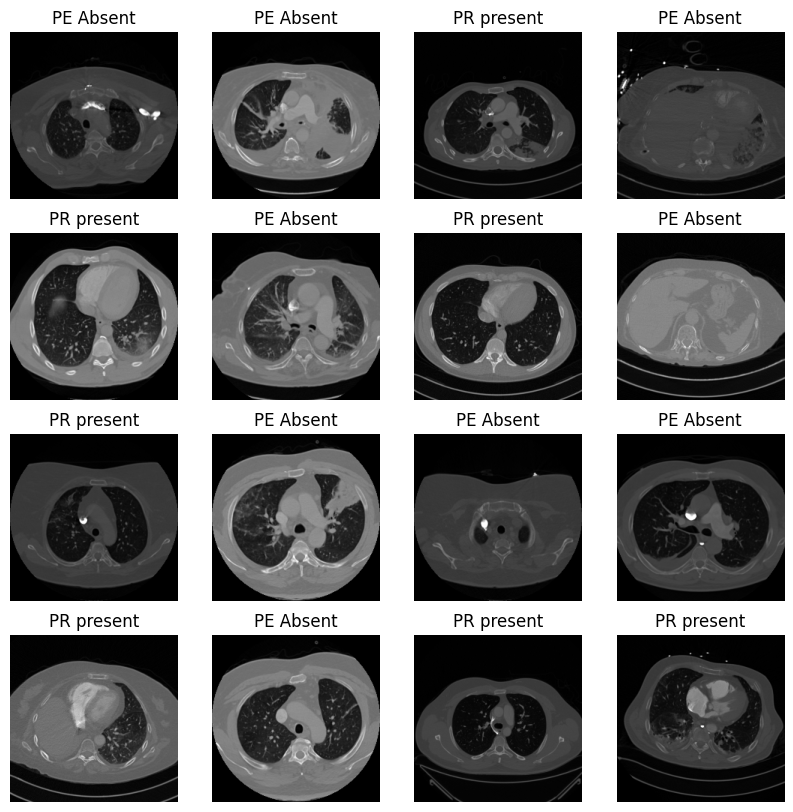

In [5]:
num_gpus = torch.cuda.device_count()
train_loader, val_loader, test_loader = getLoaders((train_z, train_o), (val_z, val_o), (test_z, test_o),num_gpus = num_gpus)
batch_img, batch_label = next(iter(train_loader))

fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i + 1)
    plt.imshow(batch_img[i].permute(1, 2, 0))
    lbl = batch_label[i]
    title = 'PR present' if lbl else 'PE Absent'
    plt.title(title)
    plt.axis(False);
plt.show()

In [6]:
print(batch_label.shape)

torch.Size([128, 1])


In [7]:
print(batch_img.shape)

torch.Size([128, 3, 224, 224])


In [8]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import swin_t
from torch.optim import Adam
import numpy as np
from tqdm import tqdm
from data import *
import os
from torch.nn.parallel import DataParallel
import logging

logging.basicConfig(filename='train.log', level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(epochs, model, train_loader, val_loader,device):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(),lr = 0.00001)
    min_val_loss = np.inf
    train_losses = []
    val_losses = []
    scheduler = ReduceLROnPlateau(optimizer, 'min', min_lr=1e-7, patience=5)
    logging.info("Starting Training")
    for epoch in range(epochs):
        train_loss = 0
        print(f'Epoch: {epoch + 1}')
        model.train()
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            out = model(images).to(device)
            # print(out)
            # print(labels)
            # print(out.shape , labels.shape)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        val_loss = 0
        logging.info("Starting Validation")
        model.eval()
        for j, data in tqdm(enumerate(val_loader),total=len(val_loader)):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            out = model(images).to(device)
            loss = criterion(out, labels)
            val_loss += loss.item()
        scheduler.step(val_loss)
        lr = get_lr(optimizer)
        print(f'Epoch: {epoch + 1} \t training loss: {train_loss / i + 1} \t validation loss: {val_loss / j + 1} learning rate: {lr}')
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print('Epoch: {} | Training loss{:.2f} | Validation loss: {:.2f} | learning rate:{}'.format(epoch+1,train_loss / i + 1,val_loss / j + 1,lr))
        logging.info('Epoch: {} | Training loss{:.2f} | Validation loss: {:.2f} | learning rate:{}'.format(epoch+1,train_loss / i + 1,val_loss / j + 1,lr))
        
    #     if min_val_loss > val_loss:
    #         min_val_loss = val_loss
    #         print('Validation loss improved, saving model.')
    #         torch.save(model.state_dict(), f'/home/akaniyar/swin_transformer/Neeraj_pretrain/best/swin_tiny_best_epoch_{epoch + 1}.pth')
    #     else:
    #         print('Saving model ...')
    #         torch.save(model.state_dict(), f'/home/akaniyar/swin_transformer/Neeraj_pretrain/all/swin_tiny_epoch_{epoch + 1}.pth')
    # # ask = input('Save final? (y/n): ')
    # # if ask == 'y' or ask == 'Y':
    # #     torch.save(model.state_dict(), 'swin_base.pth')

    return train_losses, val_losses

In [9]:
from torchvision.models import resnet18

In [10]:
model = resnet18(weights='DEFAULT' , progress =True)
model.fc = torch.nn.Linear(out_features = 1, in_features = 512)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DataParallel(model, device_ids=list(range(num_gpus)), dim=0)

model = model.to('cuda')

In [ ]:
train_loss, val_loss = train(epochs = 15 , model = model , train_loader =  train_loader , val_loader =val_loader,device = device)

In [53]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 519 kB 4.3 MB/s eta 0:00:01


In [126]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import * 
from tqdm import tqdm
from torchvision.models import swin_t
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score ,roc_curve,auc
from torch.nn.parallel import DataParallel
import logging
from torchmetrics import Accuracy as acc
device = torch.device('cuda')

# Set up logging
log_file = 'test.log'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

# Add file handler to save log messages to a file
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

accu = acc('binary')
def test(swin,test_loader,device):
    logger.info('Starting testing')
    swin.eval()
    auc_scores = []    
    running_loss = 0.0
    running_corrects = torch.zeros(15).to(device)
    total_samples = 0
    num_labels = 15
    correct = 0
    total = 0
    criterion = torch.nn.BCEWithLogitsLoss()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = swin(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            predicted_labels = torch.sigmoid(outputs) > 0.5
            predicted_probs = torch.sigmoid(outputs)
            
            running_corrects += (predicted_labels == labels).sum(dim=0).float()
            total_samples += inputs.size(0)
            y_pred.append(predicted_probs.cpu())
            y_true.append(labels.cpu())
            for i in range(len(predicted_labels)):
                if (predicted_labels[i] == True):
                    correct += 1
            
    epoch_loss = running_loss / total_samples
    print(correct,total_samples)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    
    #accur = accu(outputs.cpu(),labels.cpu())
    accur =(correct/total_samples) *100
    auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plot_roc(fpr, tpr,auc_score)
    
    logger.info('Testing Accuracy: {}% | Testing Loss{} | '.format(accur*100,epoch_loss))
    logger.info('False Positive Rate{} | True Positive Rate{} | AUC Score{} | '.format(fpr,tpr,auc_score))
    print('Testing Accuracy: {}% | Testing Loss{} | '.format(accur*100,epoch_loss))
    #print('False Positive Rate{} | True Positive Rate{} | AUC Score{} | '.format(fpr,tpr,auc_score))
    
    return epoch_loss,auc_score

def plot_roc(fpr, tpr, auc_score):
    
    plt.figure(figsize = (11,7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')            
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontweight = "bold", fontsize = 12)
    plt.ylabel('True Positive Rate',fontweight = "bold", fontsize = 12)
    plt.title('Receiver operating characteristic (ROC) Curve',fontweight = "bold", fontsize = 16)
    plt.legend(loc="lower right")
    plt.savefig('RSNAPEAUC.png')
    plt.show()
    

100%|██████████| 32/32 [00:04<00:00,  7.21it/s]


624 1000


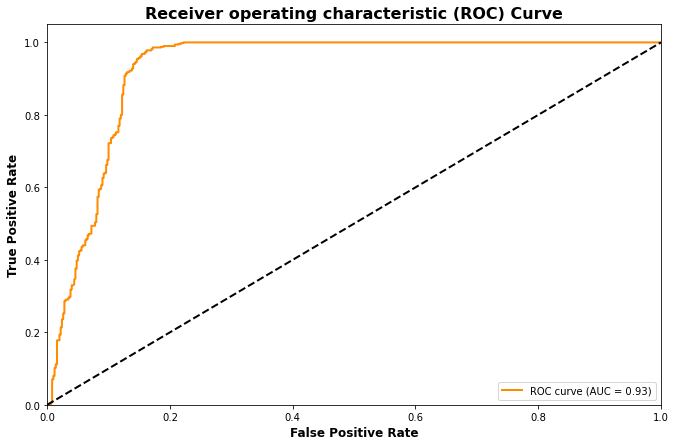

Testing Accuracy: 6240.0% | Testing Loss0.6234493799805642 | 


In [127]:
loss ,auc = test(swin = model,test_loader = test_loader ,device =device)

In [128]:
loss ,auc

(0.6234493799805642, 0.927672)

[0.4065710613651881, 0.22049311087245033, 0.11480374864879109, 0.061426018468207784, 0.03563536982983351, 0.02405718138944062, 0.017114696018989125, 0.013466174182082926, 0.010129767373972942, 0.010040592143519057, 0.010392298581936056, 0.010006335205472415, 0.009506026741176371, 0.009163684640375395, 0.008414535687142422] 
 [0.2719045840203762, 0.1981842014938593, 0.21789133176207542, 0.22656073234975338, 0.19851025007665157, 0.25572494789958, 0.25739509984850883, 0.26200442016124725, 0.24294436909258366, 0.23740786872804165, 0.3164300434291363, 0.30842577293515205, 0.26641223952174187, 0.20493297837674618, 0.2754517588764429]


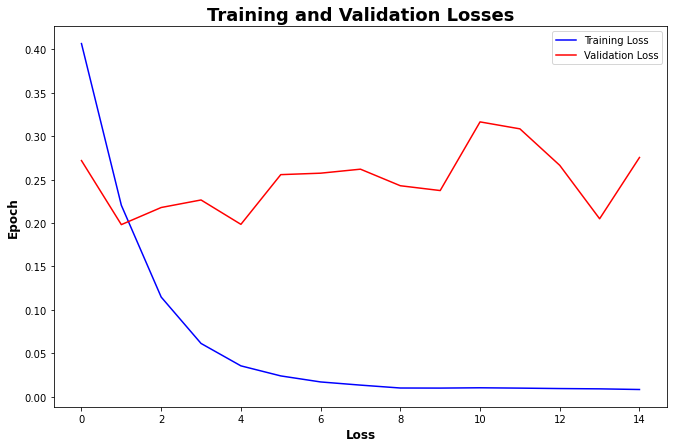

In [141]:
import matplotlib.pyplot as plt

print(train_loss,"\n",val_loss)

fig, ax = plt.subplots(figsize = (11,7))

# plot training and validation losses
ax.plot(train_loss, label='Training Loss',color='blue')
ax.plot(val_loss, label='Validation Loss',color='red')

# set plot title and labels
ax.set_title('Training and Validation Losses',fontweight = "bold", fontsize = 18)
ax.set_xlabel('Loss',fontweight = "bold", fontsize = 12)
ax.set_ylabel('Epoch',fontweight = "bold", fontsize = 12)
ax.legend()
plt.savefig('RSNAtrainingloss.png')
# show plot
plt.show()

In [ ]:
batch_img, batch_label = next(iter(test_loader))
model.eval()
pred = model(batch_img)
pred = nn.sigmoid(pred)
pred = int(pred)


fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i + 1)
    plt.imshow(batch_img[i].permute(1, 2, 0))
    lbl = batch_label[i]
    pred_lbl = pred[i]
    title = 'PR present' if lbl else 'PE Absent'
    pred_title = 'PR present' if lbl else 'PE Absent'
    plt.title(title)
    plt.axis(False);
plt.show()